In [1]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

print(sys.path)  # sanity check

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

from src.util.model import eval_model, prep_data
seed = 42

from sklego.meta import OrdinalClassifier

['/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/nickclouse/Desktop/senior-proj/SPvenv/lib/python3.10/site-packages', '/Users/nickclouse/Desktop/senior-proj/avy-forecasting']


In [2]:
dff0 = pd.read_csv("../../data/training_combined/training_combined_5.csv")
dff0['date'] = pd.to_datetime(dff0['date'])
# dff0 = dff0[dff0['slope_angle'] > 0] # Removing flat slopes increases accuracy by about 6 percent

danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])

coords_geodf = gpd.read_file("../../../data/FAC/zones/grid_coords_subset.geojson")

In [3]:
# X, y, excluded_cols = prep_data(
#     dff0, 
#     danger_levels, 
#     coords_geodf,
#     replace_missing=True, 
#     change_danger=True,
#     exclude_cols=['date','id','id_x','slope_azi', 'danger_level','altitude','slope_angle','forecast_zone_id','elevation_band','lat', 'lon', 'zone_name', 'geometry']) 
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

exclude_cols = ['date','id_x','slope_azi', 'danger_level','altitude','slope_angle','elevation_band','lat', 'lon', 'zone_name', 'geometry','danger_level.1']

X = dff0.loc[:, ~dff0.columns.isin(exclude_cols)].copy(deep=True)
X = X.fillna(0)

y = dff0['danger_level']
excluded_cols = dff0.loc[:, dff0.columns.isin(exclude_cols)].copy(deep=True)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, stratify=y)



In [4]:
rf = RandomForestClassifier(random_state=seed, n_jobs=-1,
                            max_depth=20,
                            max_features=0.5,
                            min_samples_leaf=4,
                            min_samples_split=20,
                            n_estimators=500,
                            class_weight='balanced'
                           )
oc = OrdinalClassifier(rf, n_jobs=-1)
oc.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,n_jobs,-1
,use_calibration,False
,calibration_kwargs,None
,n_estimators,500
,criterion,'gini'
,max_depth,20
,min_samples_split,20
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.5


/Users/nickclouse/Desktop/senior-proj/SPvenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OrdinalClassifier was fitted with feature names
  warnings.warn(


Train


/Users/nickclouse/Desktop/senior-proj/SPvenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OrdinalClassifier was fitted with feature names
  warnings.warn(


Accuracy 0.98
Balanced Accuracy 0.98
MAE: 0.02413092197842289
Test
Accuracy 0.93
Balanced Accuracy 0.94
MAE: 0.07997892091288662


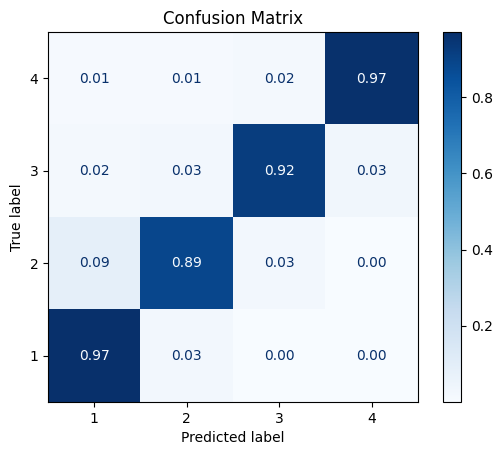

In [5]:
y_pred = oc.predict(X_test)

print("Train")
eval_model(y_train, oc.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)

/Users/nickclouse/Desktop/senior-proj/SPvenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OrdinalClassifier was fitted with feature names
  warnings.warn(


Accuracy 0.45
Balanced Accuracy 0.32
MAE: 0.6821877309682187


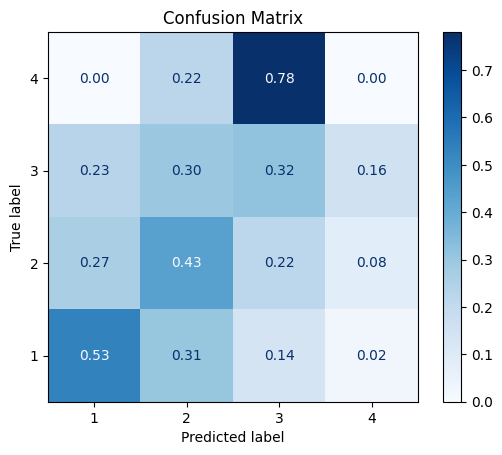

In [11]:
actual_dangers = pd.read_csv("../../data/2526_FAC/FAC_danger_levels_25.csv")

zone_map = {
    "whitefish range":"whitefish",
    "swan range":"swan",
    "flathead range & glacier np":"flathead"
}

actual_dangers['date'] = pd.to_datetime(actual_dangers['date'])
actual_dangers['zone_name'] = actual_dangers['zone_name'].apply(lambda x: zone_map[x])

curr_dff = pd.read_csv("../../data/ops25_26/new_all_predictions.csv").drop(columns=["predicted_danger"]).rename(columns={"date":"timestamp"})

val_x, val_y, val_excluded_cols = prep_data(
    curr_dff, 
    actual_dangers, 
    coords_geodf,
    replace_missing=True, 
    change_danger=False,
    exclude_cols=['date','id','id_x','slope_azi', 'danger_level','altitude','slope_angle','forecast_zone_id','elevation_band','lat', 'lon', 'zone_name', 'geometry']) 

val_x = val_x.fillna(0)

preds = oc.predict(val_x)

eval_model(val_y, preds, plot=True, norm=True)